### <center> ML-7. Прогнозирование биологического ответа (HW-3)

#### Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.
#### В качестве метрики будем использовать F1-score

In [58]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna

%matplotlib inline
plt.style.use('seaborn-v0_8')

In [59]:
# чтение дата-сета
data = pd.read_csv('data/_train_sem09.csv')

In [60]:
#  размер дата-сета
data.shape

(3751, 1777)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [62]:
data.head(2)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


1    0.54
0    0.46
Name: Activity, dtype: float64
Вывод: выборка относительно сбалансированная


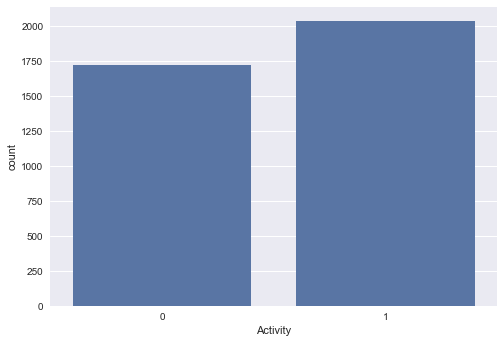

In [63]:
# Проверка сбалансированности выборки
sns.countplot(data=data, x='Activity'); # визуализируем бинарную классификацию
print(round(data['Activity'].value_counts(normalize=True),2)) # выразим в процентном соотношении
print('Вывод: выборка относительно сбалансированная')

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [64]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [65]:
# разделим дата-сет на тренировочную и тестовую выборки со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

#### <center> **Метод GridSearchCV**

#### Модель логистической регрессии

In [66]:
# создаем сетку параметров
param_grid_lr1 = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': list(np.linspace(0.01, 1, 5, dtype=float))
              }
grid_search_lr1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=30
    ), 
    param_grid=param_grid_lr1, 
    cv=5, # применяем кросс-валидацию на 5 фолдах
    n_jobs = -1
)  
%time grid_search_lr1.fit(X_train, y_train)
y_train_pred_lr1 = grid_search_lr1.predict(X_train)
y_test_pred_lr1 = grid_search_lr1.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_lr1)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr1)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr1.best_params_))

Wall time: 1min 19s
f1_score на тренировочном наборе: 0.82
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Модель случайный лес

In [67]:
# создаем сетку параметров
# для ускорения процесса сетку делаем небольшой
param_grid_rf1 = {'min_samples_leaf': [3, 4, 5, 7],
                 'max_depth': [10, 15, 20, 25, 30],
                 'criterion':['entropy','gini']
              }
            
grid_rf1 = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42, n_estimators=40), 
    param_grid=param_grid_rf1, 
    cv=5, # применяем кроссвалидацию
    n_jobs = -1,
    )  
%time grid_rf1.fit(X_train, y_train) 
y_train_pred_rf1= grid_rf1.predict(X_train)
y_test_pred_rf1 = grid_rf1.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf1)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf1)))
print("Наилучшие значения гиперпараметров: {}".format(grid_rf1.best_params_))

Wall time: 1min 16s
f1_score на тренировочном наборе: 0.97
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 3}


### <center> **RandomizedSearchCV**

#### Модель логистической регрессии

In [68]:
param_distributions_lr2 = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 5, dtype=float))}
            
random_search_lr2 = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=30), 
    param_distributions=param_distributions_lr2, 
    cv=5, # кроссвалидация
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_lr2.fit(X_train, y_train)
y_train_pred_lr2= random_search_lr2.predict(X_train) 
y_test_pred_lr2 = random_search_lr2.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_lr2)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr2)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr2.best_params_))

Wall time: 30.5 s
f1_score на тренировочном наборе: 0.82
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.01}


c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Модель случайный лес

In [69]:
param_distributions_rf2 = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_rf2 = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42, n_estimators=100), 
    param_distributions=param_distributions_rf2, 
    cv=5,
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search_rf2.fit(X_train, y_train) 
y_train_pred_rf2 = random_search_rf2.predict(X_train)
y_test_pred_rf2 = random_search_rf2.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf2)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf2)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf2.best_params_))

Wall time: 39.1 s
f1_score на тренировочном наборе: 0.94
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'min_samples_leaf': 6, 'max_depth': 30, 'criterion': 'entropy'}


### <center> Hyperopt

#### Модель логистической регрессии

In [70]:
# зададим пространство поиска гиперпараметров
penalties = ['l1', 'l2']
solvers = ['liblinear', 'saga']

space_lr3 = {
                'penalty' : hp.choice('penalty', penalties),
                'solver' : hp.choice('solver', solvers),
                'C' : hp.uniform('C', 0.01, 1),
                }

In [71]:
# зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': (params['penalty']), 
              'solver': (params['solver']), 
             'C': float(params['C'])
             }
  
    # используем эту комбинацию для построения модели
    model = LogisticRegression(**params, random_state=random_state, max_iter=50)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [72]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space_lr3, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=6, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

 17%|█▋        | 1/6 [00:02<00:14,  2.95s/trial, best loss: -0.779494746167446]

c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 3/6 [00:23<00:21,  7.25s/trial, best loss: -0.7841071594645037]

c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 83%|████████▎ | 5/6 [00:41<00:07,  7.66s/trial, best loss: -0.7904516202991784]

c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 6/6 [00:56<00:00,  9.36s/trial, best loss: -0.7904516202991784]
Наилучшие значения гиперпараметров {'C': 0.2200949458234019, 'penalty': 0, 'solver': 1}
Wall time: 56.1 s


In [73]:
# рассчитаем точность для тестовой выборки
model = LogisticRegression(
    random_state=random_state, 
    C=float(best['C']),
    penalty=penalties[best['penalty']],
    solver=solvers[best['solver']]
    
)
model.fit(X_train, y_train)

y_train_pred_lr3 = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_lr3)))
y_test_pred_lr3 = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr3)))

f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.78


c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Модель случайный лес

In [74]:
# зададим пространство поиска гиперпараметров
space_rf3 = {'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [75]:
# зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
        # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [76]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space_rf3, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 10/10 [01:27<00:00,  8.76s/trial, best loss: -0.8133136861401603]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 3.0, 'n_estimators': 175.0}
Wall time: 1min 27s


In [77]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)

y_train_pred_rf3 = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf3)))
y_test_pred_rf3 = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf3)))

f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.81


## <center> Optuna

#### Модель логистической регрессии

In [78]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  C = trial.suggest_float('C', 0.01, 1)
  #max_iter = trial.suggest_int('max_iter', 50, 500)

  # создаем модель
  model = linear_model.LogisticRegression(solver=solver,
                                          penalty=penalty,
                                          C=C,
                                          max_iter=50,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  
  # используем кроссвалидацию
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [79]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=5)

[I 2025-02-06 10:15:42,951] A new study created in memory with name: LogisticRegression
[I 2025-02-06 10:15:49,029] Trial 0 finished with value: 0.7814714345698269 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.884507552834171}. Best is trial 0 with value: 0.7814714345698269.
[I 2025-02-06 10:15:51,577] Trial 1 finished with value: 0.7847336324034249 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.7137876109960604}. Best is trial 1 with value: 0.7847336324034249.
c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-02-06 10:16:09,767] Trial 2 finished with value: 0.7922607326469988 and parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.2810986548580396}. Best is trial 2 with value: 0.7922607326469988.
[I 2025-02-06 10:16:11,377] Trial 3 finished with value: 0.7862536716404888 and parameters

Wall time: 41.2 s


In [80]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'solver': 'saga', 'penalty': 'l1', 'C': 0.2810986548580396}
f1_score на обучающем наборе: 0.79


In [81]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=42, )
model.fit(X_train, y_train)

y_train_pred_lr4 = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_lr4)))
y_test_pred_lr4 = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr4)))

f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.78


c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Модель случайный лес

In [82]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  
  # используем кроссвалидацию
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [83]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2025-02-06 10:16:34,420] A new study created in memory with name: RandomForestClassifier
[I 2025-02-06 10:16:45,451] Trial 0 finished with value: 0.802832453588084 and parameters: {'n_estimators': 216, 'max_depth': 21, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.802832453588084.
[I 2025-02-06 10:16:54,004] Trial 1 finished with value: 0.8078871682954251 and parameters: {'n_estimators': 155, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8078871682954251.
[I 2025-02-06 10:17:02,106] Trial 2 finished with value: 0.8113287414906528 and parameters: {'n_estimators': 151, 'max_depth': 35, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8113287414906528.
[I 2025-02-06 10:17:18,632] Trial 3 finished with value: 0.8120037765745035 and parameters: {'n_estimators': 293, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8120037765745035.
[I 2025-02-06 10:17:33,842] Trial 4 finished with value: 0.8103624987406184 and parameters: {'n_es

Wall time: 1min 54s


In [84]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 195, 'max_depth': 29, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.81


In [85]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_train_pred_rf4 = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf4)))
y_test_pred_rf4 = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf4)))

f1_score на обучающем наборе: 0.96
f1_score на тестовом наборе: 0.80


### Заключение

В ходе работы было обучено две модели: LogisticRegression и RandomForestClassifier. Для моделей был осуществлён подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации: GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna. Также во всех методах возвращены наилучшие значения гиперпараметров и была использована кроссвалидация. Для оценки качества применения обучения моделей была использована метрика F1-score.
Выборка была разделена на тренировочную и тестовую с применение стратификации и коэфф 0,2.
Результаты значений метрики f1-score:
<br><b>Метод GridSeachCV:</b>
<br><b>Модель LogisticRegression:</b>
<br>Время обучения модели: 1m. 19s
<br>Тренировочная выборка: 0.82
<br>Тестовая выборка: 0.78
<br><b>Модель RandomForestClassifier:</b>
<br>Время обучения модели: 1m. 16s
<br>Тренировочная выборка: 0.97
<br>Тестовая выборка: 0.79


<br><b>Метод RandomizedSearchCV:</b>
<br><b>Модель LogisticRegression:</b>
<br>Тренировочная выборка: 0.82
<br>Тестовая выборка: 0.78
<br><b>Модель RandomForestClassifier:</b>
<br>Время обучения модели: 30.5s
<br>Тренировочная выборка: 0.94
<br>Тестовая выборка: 0.80

<br><b>Метод Hyperopt:</b>
<br><b>Модель LogisticRegression:</b>
<br>Время обучения модели: 56.1s
<br>Тренировочная выборка: 0.83
<br>Тестовая выборка: 0.78
<b>Модель RandomForestClassifier:</b>
<br>Время обучения модели: 1m. 27,6s
<br>Тренировочная выборка: 0.97
<br>Тестовая выборка: 0.81

<br><b>Метод Optuna:</b>
<br><b>Модель LogisticRegression:</b>
<br>Время обучения модели: 42.1s
<br>Тренировочная выборка: 0.83
<br>Тестовая выборка: 0.78
<br><b>Модель RandomForestClassifier:</b>
<br>Время обучения модели: 1m. 54s
<br>Тренировочная выборка: 0.96
<br>Тестовая выборка: 0.81

<br><b>Вывод:</b> все методы показали незначительную разницу в значениях метрик на тестовой выборке – от 0.78 до 0.81. Лучшая метрика достигнута на модели RandomForestClassifier методами Hyperopt и Optuna.
На тренировочных выборках были замечены признаки переобучения модели RandomForestClassifier при применении методов Hyperopt и Optuna, метрики показали значения 0.96 и 0.97, значения метрик на тренировочной выборке заметно отличаются.
<br>Более ровно обучалась модель LogisticRegression при применении всех методов.
<br>Время обучения анализировать в данном обучении нецелесообразно, т.к. параметры методов подбирались таким образом, чтобы не затратить большого временного ресурса для демонстрации обучения моделей, указанными выше методами подбора гиперпараметров.